# Imports

In [1]:
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import argparse
from torchvision import models, transforms
from torch.nn import functional as F
from torch import topk

# Define image transformations

In [2]:
# define the transforms, resize => tensor => normalize
transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    ])

# Load RESNET-18

In [3]:
# load the model
model = models.resnet18(pretrained=True).eval()

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
model._modules.get('layer4').register_forward_hook(hook_feature)

# get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

C:\Users\edvin\anaconda3\envs\deepimg\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\edvin\anaconda3\envs\deepimg\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Intuition

In [4]:
weight_softmax.shape

(1000, 512)

Last convolutional layer from Resnet18 gives layer of shape: 7x7x512 (512 featuremaps, each of size 7x7)

GAP on the last layer returns a tensor of size: 1x1x512

We then have a fully connected layer with a weight matrix of size (1000,512), which gives final output vector of size (1000x1)

# Load labels

In [5]:
def load_synset_classes(file_path):
    # load the synset text file for labels
    all_classes = []
    with open(file_path, 'r') as f:
        for line in f.readlines():
            label = line.strip().split(':', 1)[1].strip(" '").split(',')[0]
            label = label.strip("'")  # Remove any remaining single quotes
            all_classes.append(label)
    return all_classes

# get all the classes in a list
all_classes = load_synset_classes('labels.txt')

# CAM functions

In [6]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    """
    generate the class activation maps upsample to 256x256
    
    feature_conv.shape = 1x512x7x7
    weight_softmax.shape = 1000x512
    
    weight_softmax[0].shape = 1x512
    feature_conv.reshape((nc, h*w)).shape = 512x49
    """
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
        
    # weighted sum of all feature maps
    cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w))) # cam.shape = 1x49
    cam = cam.reshape(h, w) # cam.shape = 7x7

    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)

    output_cam = cv2.resize(cam_img, size_upsample) # output_cam.shape = 256x256
        
    return output_cam

In [7]:
def show_cam(CAM, width, height, orig_image, class_idx, all_classes, save_name):
        heatmap = cv2.applyColorMap(cv2.resize(CAM,(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + orig_image * 0.5
        
        # put class label text on the result
        result = cv2.putText(result, all_classes[class_idx], (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 255, 0), 2)
        result = result.astype(np.float32) # Cast to float32
        result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) # Convert to RGB
        
        # Plot image
        plt.imshow(result/255.)
       
        # Settings
        plt.axis('off')
        plt.show()
        
        # Save output
        cv2.imwrite(f"outputs/output_{save_name}", result)
        features_blobs.clear()

In [75]:
def transform_and_forward(image, transforms,model, k):
    # apply the image transforms
    image_tensor = transforms(image).unsqueeze(0)

    # forward pass through model
    outputs = model(image_tensor)

    # get the softmax probabilities
    probs = F.softmax(outputs, dim=1).data.squeeze()

    # get the class indices of top k probabilities
    class_idx = topk(probs, k)[1].int()
    
    return class_idx, probs

In [76]:
def get_CAM_overlay(CAM, width, height, orig_image, class_idx, all_classes):
    heatmap = cv2.applyColorMap(cv2.resize(CAM,(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + orig_image * 0.5

    # put class label text on the result
    #result = cv2.putText(result, all_classes[class_idx], (30, 80), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 255, 0), 2)
    result = result.astype(np.float32) # Cast to float32
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) # Convert to RGB
    result = result/255

    # Clear for next image
    features_blobs.clear()
    
    return result

# Load images

Available classes can be found: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

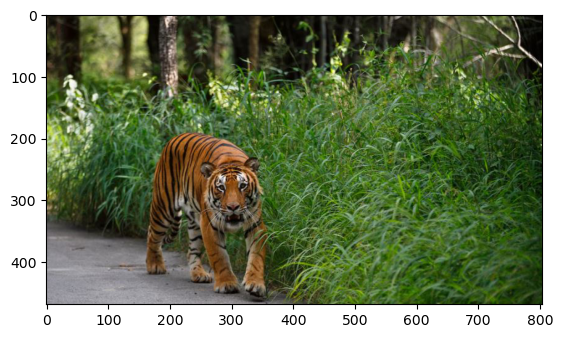

In [243]:
#input_file = "group.png"
input_file = "tiger.jpg"


image = cv2.imread(input_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape

imshow(image)

# Generate maps and visualize results

In [244]:
# Feed image, get 4 highest scores
class_idx, probs = transform_and_forward(image,transforms,model,1000)

first = 0
second = 1
third = 2
fourth = 3 


# generate cam for highest prediction
CAM1 = returnCAM(features_blobs[0], weight_softmax, class_idx[first])

# generate cam for second highest prediction
CAM2 = returnCAM(features_blobs[0], weight_softmax, class_idx[second])

# generate cam for third highest prediction
CAM3 = returnCAM(features_blobs[0], weight_softmax, class_idx[third])

# generate cam for fourth highest prediction
CAM4 = returnCAM(features_blobs[0], weight_softmax, class_idx[fourth])

# Generate overlays

In [245]:
image_cam1 = get_CAM_overlay(CAM1, width, height, image, class_idx[first], all_classes) 
image_cam2 = get_CAM_overlay(CAM2, width, height, image, class_idx[second], all_classes) 
image_cam3 = get_CAM_overlay(CAM3, width, height, image, class_idx[third], all_classes) 
image_cam4 = get_CAM_overlay(CAM4, width, height, image, class_idx[fourth], all_classes) 

# Plot results

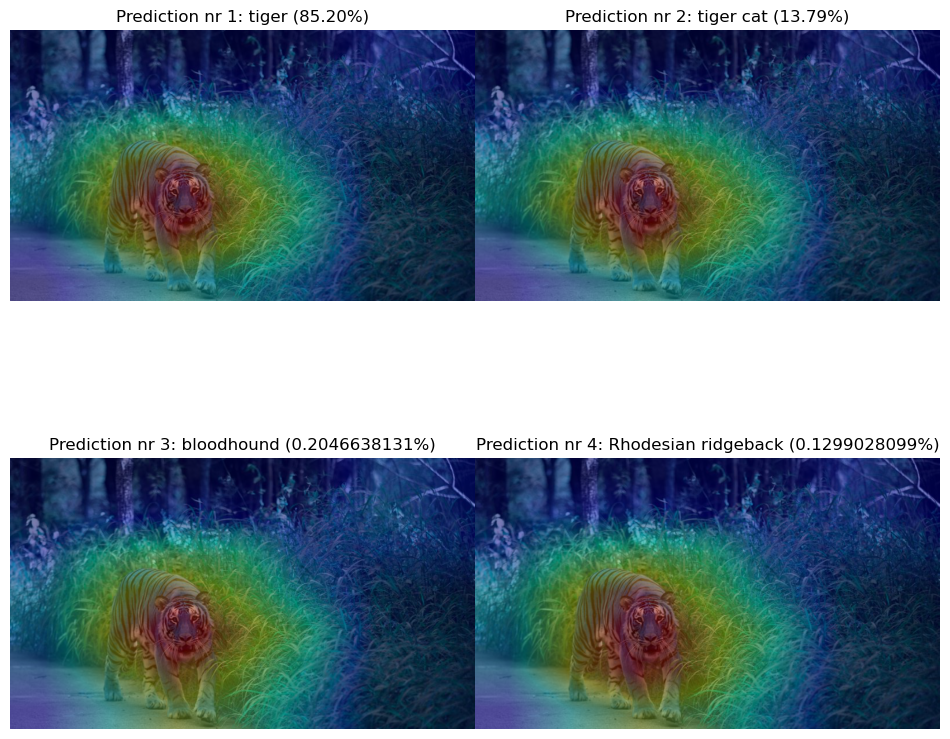

In [246]:
# Display the images in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Set aspect ratio and adjust the space between subplots
for ax in axs.flat:
    ax.set_aspect('equal')
plt.subplots_adjust(wspace=0.0001, hspace=0.25)

# Display the original image
axs[0,0].imshow(image_cam1)
axs[0,0].set_title(f'Prediction nr {first+1}: {all_classes[class_idx[first]]} ({probs[class_idx[first]]*100:.2f}%)')
axs[0,0].axis('off')

# Display the flipped and noisy image
axs[0,1].imshow(image_cam2)
axs[0,1].set_title(f'Prediction nr {second+1}: {all_classes[class_idx[second]]} ({probs[class_idx[second]]*100:.2f}%)')
axs[0,1].axis('off')

# Display the noisy image
axs[1,0].imshow(image_cam3)
axs[1,0].set_title(f'Prediction nr {third+1}: {all_classes[class_idx[third]]} ({probs[class_idx[third]]*100:.10f}%)')
axs[1,0].axis('off')

# Display the enhanced image
axs[1,1].imshow(image_cam4)
axs[1,1].set_title(f'Prediction nr {fourth+1}: {all_classes[class_idx[fourth]]} ({probs[class_idx[fourth]]*100:.10f}%)')
axs[1,1].axis('off')

# Show the grid of images
plt.savefig("outputs/group_cam.jpg")
plt.show()